# Задача

Кроме скрытой задачи научиться делать что-то прикольное с глубоким обучением я попробую классифицировать фильмы по новому крошечному датасету MovieLense, а так же предсказать фильм для себя

# Данные и функции

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder



#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense , merge
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau


from keras.layers.merge import dot
from keras.models import Model


# specifically for deeplearning.
from keras.layers import Dropout, Flatten,Activation,Input,Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn
from IPython.display import SVG
 
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import collections


#TL pecific modules
from keras.applications.vgg16 import VGG16


# clustering
from sklearn.manifold import TSNE
from nltk.cluster import KMeansClusterer
import nltk
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster


# draw
import matplotlib.pyplot as plt
import plotly.express as px

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

In [ ]:
path = '/content/models-recsys/'
!mkdir models-recsys
%cd models-recsys
!wget -c https://332320.selcdn.ru/hsehci2020/movielens-recsys/ml-latest-small.zip

/content/models-recsys/models-recsys
--2020-12-22 23:22:10--  https://332320.selcdn.ru/hsehci2020/movielens-recsys/ml-latest-small.zip
Resolving 332320.selcdn.ru (332320.selcdn.ru)... 92.53.68.202, 92.53.68.204, 92.53.68.201, ...
Connecting to 332320.selcdn.ru (332320.selcdn.ru)|92.53.68.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/x-zip-compressed]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  1.13MB/s    in 0.8s    

2020-12-22 23:22:12 (1.13 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [ ]:
import zipfile
import os
zip_ref = zipfile.ZipFile(os.path.join(path,'ml-latest-small.zip'), "r")
zip_ref.extractall()
movies_df = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

import re
movies_df['year'] = movies_df.title.apply(lambda x: re.search('(\d{4})',x).group(0) if re.search('\((\d{4})\)',x) else 0)
movies_df['year'] = movies_df['year'].astype('int')
unique_movies = pd.DataFrame(ratings['movieId'].unique(),
                   columns=['movieId'])
unique_movies['movieId2'] = range(0, len(unique_movies))

movies2 = movies_df.merge(unique_movies, on = "movieId")
movies2 = movies2.drop(columns = ['movieId'])
movies2 = movies2.rename(columns={"movieId2": "movieId"})
movies_df = movies2
# movies_df.describe()

ratings = pd.merge(ratings, unique_movies, on = "movieId")
ratings.drop(columns = ['movieId'], inplace=True)
ratings = ratings.rename(columns={"movieId2": "movieId"})
# if we need year
ratings = pd.merge(ratings, movies_df)
ratings.drop(columns = ['title', 'genres'], inplace=True)

top_movies = ratings.groupby('movieId')['userId'].count().reset_index(name="reviews").sort_values(ascending=False, by="reviews").head(50).merge(movies_df, on = "movieId")

Датасет movieLense в первую очередь интересен 2 вещами: 


1.   Это реальные оценки реальных пользователей на реальных фильмах
2.   Датасет очень мило нарезан на форматы в которых не страшно работать,
так ml-latest-small который я использую рекомендован для обучения

он доступен на офиофициальном сайте проекта http://files.grouplens.org/datasets/movielens/ml-latest-small.zip


In [ ]:
df=ratings

In [ ]:
# df = px.data.tips()
fig = px.histogram(df[(df['year']>1930) & (df['year']<=2020)]['year'], x="year", title='Histogram of films over the years',)
fig.show()

Не смотря на то, что в наших данных есть небольшой шум и неправильно собранные даты, большинство наблюдений находятся в промежутка с 70-х по 2018, когда датасет был выгружен. 

Пик в 1995 году имеет искусственную природу и пришёл по наследству из предыдущей версии датасета 1998 года

In [ ]:
fig = px.histogram(df['rating'], x="rating", title='Histogram of user ratings',)
fig.show()

Что касается рейтинга, то датасет содержит 100836 оценок, которые распределены достаточно типично: 
чаще всего люди ставят 4, однако MovieLense позволял ставить дробные оценки, например 4.5, поэтому формально шкала 10 балльная, однако пользователям привычнее целые значения

# Добавить пользовательский рейтинг
Так как специфика модели не позволяет использовать предсказание на новых данных, придётся добавить мои оценки в основной датасет. Они едва ли поменяют оценку модели, но будет проще обращаться к моим эмбедингам.

По умолчанию этот шаг лучше пропустить, так единственный относитель быстрый способ это добавить пользовательские данные в модель это передать туда вектор длинной в количество фильмов.

Чтобы сделать этот процес слегка человечнее следующий код создаст экселевский лист со списком всех фильмов. Там я проставил оценки напротив примерно 50 фильмов, а затем загрузил в модель

In [ ]:
USER_RATINGS = True #@param {type:"boolean"}

In [ ]:
# @title Run to create a spreadsheet, then use it to enter your ratings.
# Authenticate user.
if USER_RATINGS:
  auth.authenticate_user()
  gc = gspread.authorize(GoogleCredentials.get_application_default())
  # Create the spreadsheet and print a link to it.
  try:
    sh = gc.open('MovieLens-final')
  except(gspread.SpreadsheetNotFound):
    sh = gc.create('MovieLens-final')

  worksheet = sh.sheet1
  titles = movies_df['title'].values
  cell_list = worksheet.range(1, 1, len(titles), 1)
  for cell, title in zip(cell_list, titles):
    cell.value = title
  worksheet.update_cells(cell_list)
  print("Link to the spreadsheet: "
        "https://docs.google.com/spreadsheets/d/{}/edit".format(sh.id))

Link to the spreadsheet: https://docs.google.com/spreadsheets/d/1u7A9sh1Q-nNwhdKOCjzIvmATVMYjHh8LUQoa7HDXZ9g/edit


In [ ]:
df['userId'].max()

610

In [ ]:
# @title Run to load your ratings.
# Load the ratings from the spreadsheet and create a DataFrame.
if USER_RATINGS:
  my_ratings = pd.DataFrame.from_records(worksheet.get_all_values()).reset_index()
  my_ratings = my_ratings[my_ratings[1] != '']
  my_ratings = pd.DataFrame({
      'userId': 611,
      'movieId': list(map(str, my_ratings['index'])),
      'rating': list(map(float, my_ratings[1])),
  })
  my_ratings['movieId'] = my_ratings['movieId'].astype('int64')
  my_ratings['userId'] = my_ratings['userId'].astype('int64')
  my_ratings['rating'] = my_ratings['rating'].astype('int64')
  # Remove previous ratings.
  ratings = ratings[ratings.userId != 611]
  # Add new ratings.
  ratings = ratings.append(my_ratings, ignore_index=True)
  # Add new user to the users DataFrame.
  # if users.shape[0] == 610:
  #   users = users.append(users.iloc[610], ignore_index=True)
  #   users["userId"][610] = 611
  print("Added your %d ratings; you have great taste!" % len(my_ratings))
  # ratings[ratings.userId=="611"].merge(movies[['movieId', 'title']])

Мои оценённые фильмы

In [ ]:
ratings = ratings.drop(columns=['timestamp', 'year'])

In [ ]:
my_ratings.tail(5)

,userId,rating,timestamp,movieId
52,611,5,1.537799e+09,77893
53,611,4,1.537799e+09,117867
54,611,1,1.537799e+09,118082
55,611,2,1.537799e+09,130050
56,611,5,1.537799e+09,130052


И вот они появились в общем списке оценок

In [ ]:
ratings[ratings['userId'] == 611].tail(5)

,userId,rating,timestamp,movieId
100794,611,5.0,1.537799e+09,9629
100857,611,4.0,1.537799e+09,9691
100859,611,1.0,1.537799e+09,9692
100863,611,2.0,1.537799e+09,9695
100865,611,5.0,1.537799e+09,9696


Проверим, что я попал в данные

In [ ]:
df['userId'].max()

611

Далее идут несколько чанков преобразований и построение модели, которые можно пропустить я специально 

# Prepare data

Сперва переведём Id из индексов в числа, это нам нужно так как модель боится пропусков и где-то там внутри есть цикл

In [ ]:
df.userId = df.userId.astype('category').cat.codes.values
df.movieId = df.movieId.astype('category').cat.codes.values
df['userId'].value_counts(ascending=True)

575      20
568      20
52       20
256      20
206      20
       ... 
273    1346
447    1864
473    2108
598    2478
413    2698
Name: userId, Length: 612, dtype: int64

## Utility matrix

Затем сделаем матрицу полезности длинной в количество пользователей, а шириной в количество фильмов

In [ ]:
# creating utility matrix.
index=list(df['userId'].unique())
columns=list(df['movieId'].unique())
index=sorted(index)
columns=sorted(columns)
 
util_df=pd.pivot_table(data=df,values='rating',index='userId',columns='movieId')
# Nan implies that user has not rated the corressponding movie.

так как нейронки пока плохо работают с пропусками, заменим их на 0.
Это самое главное допущение модели, так как она не будет поощрять разнообразие и поиск нового.
Альтернативный подход с заполнением средними значениями, как для пользователя, так и для фильма давал лучшую модель с точки зрения RMSE, но как печально известный конкурс нетфликса был практически бесполезен

In [ ]:
util_df.fillna(0)

movieId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9684,9685,9686,9687,9688,9689,9690,9691,9692,9693,9694,9695,9696,9697,9698,9699,9700,9701,9702,9703,9704,9705,9706,9707,9708,9709,9710,9711,9712,9713,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.0,4.0,4.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,4.0,5.0,3.0,3.0,5.0,4.0,4.0,5.0,4.0,3.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,5.0,5.0,3.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,5.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,3.0,0.0,5.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2.5,2.0,0.0,4.5,4.5,3.0,0.0,4.0,0.0,0.0,3.0,2.5,2.5,3.0,0.0,3.5,5.0,3.0,4.0,0.0,3.0,0.0,2.0,3.0,4.5,3.0,3.0,2.0,4.0,3.5,1.5,3.5,3.0,3.0,4.0,0.5,3.0,3.5,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
609,5.0,0.0,5.0,5.0,4.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0,5.0,0.0,0.0,0.0,3.0,0.0,3.5,0.0,5.0,4.5,5.0,0.0,3.5,0.0,0.0,0.0,0.0,4.5,4.5,0.0,4.5,0.0,0.0,0.0,...,4.0,3.0,4.0,3.5,3.5,3.0,5.0,4.0,3.5,3.5,4.0,3.0,3.5,4.5,3.5,3.5,3.5,4.0,1.5,5.0,3.0,3.0,4.0,4.0,3.5,3.0,4.0,0.5,4.0,4.0,3.0,3.5,3.5,3.5,3.5,2.5,4.5,3.0,3.5,3.5


дальше просто переведём Id в специальный формат Id

In [ ]:
users = df.userId.unique()
movies = df.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [ ]:
df['userId'] = df['userId'].apply(lambda x: userid2idx[x])
df['movieId'] = df['movieId'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(df)) < 0.8
train = df[split]
valid = df[~split]
print(train.shape , valid.shape)

(80573, 3) (20377, 3)


И установим количество измерений или латентных факторов на уровне 50. На датасете 98 года это значение давало наилучший результат, поэтому будем использовать его здесь

In [ ]:
n_latent_factors=50
n_movies=len(df['movieId'].unique())
n_users=len(df['userId'].unique())

Создадим слои для сети

In [ ]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec=Flatten(name='FlattenUsers')(user_embedding)
user_vec=Dropout(0.40)(user_vec)
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)
movie_vec=Dropout(0.40)(movie_vec)

In [ ]:
sim=dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)

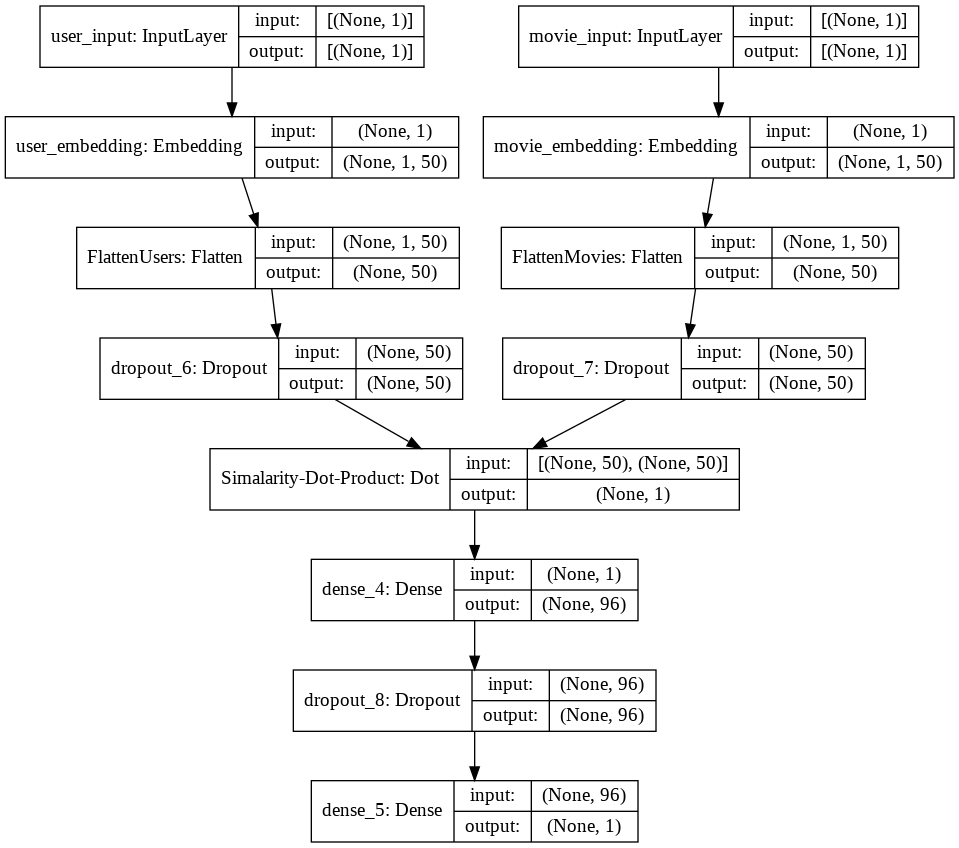

In [ ]:
nn_inp=Dense(96,activation='relu')(sim)
nn_inp=Dropout(0.4)(nn_inp)
nn_inp=Dense(1, activation="linear")(nn_inp)
nn_model =keras.models.Model([user_input, movie_input],nn_inp)
# nn_model.summary()

keras.utils.plot_model(nn_model, show_shapes=True) 

Архитектура такая:
модель берет на вход 2 слоя -- пользователей и фильмы
каждый из слоёв переносится в эмбединги 
Затем, так как мы хотим получить 1 вектор из 50 характеристик, который будет описывать пользователя (или фильм), мы преобразуем это безобразие в длинный вектор
затем будем смотреть на сходство этих векторов в Dot Product, который находит близкие вектора, почти как косинусное расстояние.
следущие слои будут обрывать слабые связи, чтобы модель не переобучилась
Так на выходе будет 1 значение рейтиг, который поставит пользователь фильму

# compile the model

все всегда использовали адам

In [ ]:
nn_model.compile(optimizer=Adam(lr=1e-3),loss='mse')

на самом деле модели хватит и 30 эпох, но нужно увидеть плоский хвост на картинке

In [ ]:
batch_size=128
epochs=40

In [ ]:
History = nn_model.fit([train.userId,train.movieId],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.userId,valid.movieId],valid.rating),
                              verbose = 1)

Epoch 1/40
630/630 [==============================] - 6s 8ms/step - loss: 5.8245 - val_loss: 1.0916
Epoch 2/40
630/630 [==============================] - 5s 8ms/step - loss: 1.2440 - val_loss: 1.0896
Epoch 3/40
630/630 [==============================] - 5s 8ms/step - loss: 1.1684 - val_loss: 0.9643
Epoch 4/40
630/630 [==============================] - 5s 8ms/step - loss: 0.9150 - val_loss: 0.8976
Epoch 5/40
630/630 [==============================] - 5s 8ms/step - loss: 0.7808 - val_loss: 0.8698
Epoch 6/40
630/630 [==============================] - 5s 8ms/step - loss: 0.7062 - val_loss: 0.8570
Epoch 7/40
630/630 [==============================] - 5s 8ms/step - loss: 0.6547 - val_loss: 0.8448
Epoch 8/40
630/630 [==============================] - 5s 8ms/step - loss: 0.6183 - val_loss: 0.8385
Epoch 9/40
630/630 [==============================] - 5s 8ms/step - loss: 0.5806 - val_loss: 0.8323
Epoch 10/40
630/630 [==============================] - 5s 8ms/step - loss: 0.5519 - val_loss: 0.8291

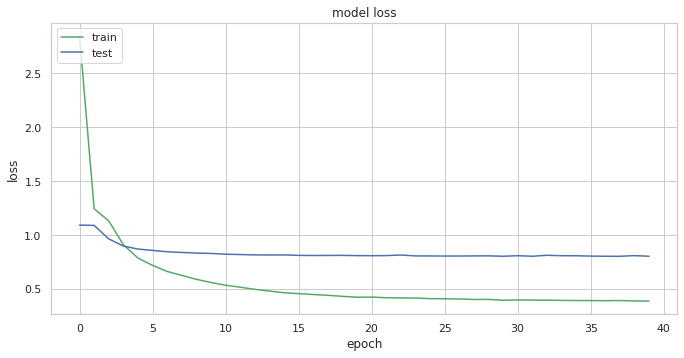

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

чётко видим что модель перестала улучшаться примерно после 20 подхода

In [ ]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])

In [ ]:
nn_model.evaluate([train.userId,train.movieId],train.rating)

2518/2518 [==============================] - 3s 998us/step - loss: 0.2583 - coeff_determination: 0.6703


[0.19757770001888275, 0.756079912185669]

Финальная модель объяснила порядка 66% дисперсии, что на разряженных данных достаточно хороший результат. Мы могли бы значительно увеличить этот показатель если бы использовали полный датасет, но доступные мощности не позволяют таких хотелок.

#Extract Movie embedding

так как мы хотим посмотерть на похожие фильмы, а так же убедиться в том, что модель действительно что-то предсказывает, то посчитаем эмбединги для фильмов

In [ ]:
movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
MOVIE_EMBEDDING_LIST = []
MOVIE_EMBED_MAP = collections.defaultdict()

In [ ]:
UNIQUE_MOVIE_IDS = movies_df['movieId'].unique()

In [ ]:
UNIQUE_MOVIE_IDS.max()

9723

Прогоним каждый из фильмов через суб модель

In [ ]:
for _id in UNIQUE_MOVIE_IDS:
    emb = movie_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    MOVIE_EMBEDDING_LIST.insert(_id, val)
    MOVIE_EMBED_MAP[_id] = val

# Кластеры на 50 самых популярных фильмах, чтобы получилось их интерпретировать

Но так как всего фильмов более 9 тысяч, ограничимся 50 самыми популярными

In [ ]:
MOVIE_EMBEDDING_LIST_TOP = list( MOVIE_EMBEDDING_LIST[i] for i in top_movies['movieId'] )
top_movies_emb = pd.DataFrame(np.array(MOVIE_EMBEDDING_LIST_TOP).reshape(len(MOVIE_EMBEDDING_LIST_TOP),50))
top_movies_emb['title'] = top_movies['title']
top_movies_emb = top_movies_emb.set_index('title')

top_movies_200 = ratings.groupby('movieId')['userId'].count().reset_index(name="reviews").sort_values(ascending=False, by="reviews").head(200).merge(movies_df, on = "movieId")
MOVIE_EMBEDDING_LIST_TOP_200 = list( MOVIE_EMBEDDING_LIST[i] for i in top_movies_200['movieId'] )
all_movies_emb = pd.DataFrame(np.array(MOVIE_EMBEDDING_LIST_TOP_200).reshape(len(MOVIE_EMBEDDING_LIST_TOP_200),50))
all_movies_emb['title'] = movies_df['title']
all_movies_emb = all_movies_emb.set_index('title')
top_movies

,movieId,reviews,title,genres,year
0,20,329,Forrest Gump (1994),Comedy|Drama|Romance|War,1994
1,232,317,"Shawshank Redemption, The (1994)",Crime|Drama,1994
2,16,307,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994
3,34,279,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,1991
4,166,278,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999
5,15,251,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,1977
6,26,238,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,1993
7,7,237,Braveheart (1995),Action|Drama|War,1995
8,478,224,Terminator 2: Judgment Day (1991),Action|Sci-Fi,1991
9,28,220,Schindler's List (1993),Drama|War,1993


Чтобы кластеризовать фильмы будем использовать метрику косинусного расстояния, так как мы всё-таки работаем с эмбедингам 

In [ ]:
cos_dist = pdist(top_movies_emb, 'cosine')

А кластеризовать будем методом варда, чтобы мы наглядно увидеть попарную кластеризацию фильмов. 

In [1]:
mergings = linkage(top_movies_emb, method='average', metric = 'cosine')
dendrogram(mergings,
           leaf_rotation=90,
           leaf_font_size=7,
           labels = top_movies_emb.index
           )
plt.title("method='average', metric = 'cosine'", fontsize=16)
plt.show()

clusts_cos = fcluster(mergings, t = 1.1)

NameError: ignored

In [ ]:
clusts_cos

array([5, 2, 5, 5, 5, 5, 1, 5, 4, 5, 5, 5, 5, 4, 5, 5, 1, 7, 5, 5, 5, 7,
       5, 3, 7, 5, 7, 7, 4, 5, 6, 7, 4, 7, 5, 5, 3, 1, 2, 1, 5, 3, 3, 7,
       5, 7, 4, 7, 3, 7], dtype=int32)

Из заметного, звёздные войны практически сразу попали в 1 кластер, то же произошло и историей игрушек и Миссис Даутфайр -- старые фильмы которые смотрели все семьёй. Так же как и Алладин и Шрек. Из очевидных промахов это Властелин Колец, который был очень сильно разнесён.

## Нарисуем это всё в двумерном пространсте

In [ ]:
# df = top_movies_emb

features = top_movies_emb.loc[:, :]

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(features)

projections_df = {'x':  projections[:,0],
        'y': projections[:,1],
         'title' : top_movies_emb.index,
         'cluster' : clusts_cos
        }

fig = px.scatter(
    projections_df, x='x', y='y', text = 'title',#top_movies_emb.index,
    color='cluster', labels={'color': 'cluster'}
)
fig.show()

В центре много фильмов, которые были популярны у широкой аудитории.

Чуть более сложные, триллеры фильмы вроде обычных подозреваемы, фарго и молчания егннят относятся к одному кластеру и смещены вверх вправо



# Что у нас попало в кластеры

In [ ]:
top_movies["cluster"] = clusts_cos

In [ ]:
top_movies[top_movies['cluster'] == 1]

,movieId,reviews,title,genres,year,cluster
6,26,238,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,1993,1
16,42,202,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,1996,1
37,101,165,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi,1997,1
39,37,162,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller,1996,1


В первый кластер попали те фильмы что я бы отнёс к современной классике, но на самом деле это просто топ imdb. Так сказать лучшие из популярных фильмов

In [ ]:
top_movies[top_movies['cluster'] == 3]

,movieId,reviews,title,genres,year,cluster
23,33,189,Batman (1989),Action|Crime|Thriller,1989,3
36,744,170,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...,2001,3
41,444,159,Memento (2000),Mystery|Thriller,2000,3
42,22,157,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,1994,3
48,27,144,Mrs. Doubtfire (1993),Comedy|Drama,1993,3


Третий класте это блокбастеры, фильмы про приключения. Как туда попал Гладиатор я не совсем понимаю, но скорее всего это популярный фильм ридли скота, который также снял Чужих и Бегущего по лезвию, которые могли бы попасть в этот кластер 

In [ ]:
top_movies[top_movies['cluster'].isin([5, 9])]

,movieId,reviews,title,genres,year,cluster
0,20,329,Forrest Gump (1994),Comedy|Drama|Romance|War,1994,5
2,16,307,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994,5
3,34,279,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,1991,5
4,166,278,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999,5
5,15,251,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,1977,5
7,7,237,Braveheart (1995),Action|Drama|War,1995,5
9,28,220,Schindler's List (1993),Drama|War,1993,5
10,192,218,Fight Club (1999),Action|Crime|Drama|Thriller,1999,5
11,0,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5
12,68,211,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,1980,5


Ну и условно детские фильмы, или фильмы которые смотрят с родители

# Предсказания фильмов для меня

Попросим модель предсказать оценку для всех фильмов для 611 пользователя. 611 пользователь это я

In [ ]:
uid = pd.Series(np.repeat(611,len(unique_movies['movieId2'])))
mid = pd.Series(unique_movies['movieId2'])
new = [uid,mid]
# new

In [ ]:
p1 = nn_model.predict(new)
movies_df_seve = movies_df
movies_df_seve['pred_rating'] = p1

и отсортируем предсказание по рейтингу. Чем выше рейтинг, тем больше шансов, что мне понравится фильм

In [ ]:
movies_df_seve = movies_df_seve[~movies_df_seve['movieId'].isin(my_ratings['movieId'])]
movies_df_seve.sort_values('pred_rating' ,ascending = False).head(50).tail(20)

,title,genres,year,movieId,pred_rating
2422,Woman in the Dunes (Suna no onna) (1964),Drama,1964,5077,4.688894
1370,Deep Impact (1998),Drama|Sci-Fi|Thriller,1998,995,4.682497
6012,Elizabethtown (2005),Comedy|Drama|Romance,2005,5928,4.674560
1596,"Secret of NIMH, The (1982)",Adventure|Animation|Children|Drama,1982,137,4.661680
2934,Sorority House Massacre (1986),Horror,1986,8744,4.652657
7677,"Separation, A (Jodaeiye Nader az Simin) (2011)",Drama,2011,2528,4.647640
318,I Love Trouble (1994),Action|Comedy,1994,615,4.643225
2916,Remember the Titans (2000),Drama,2000,739,4.622972
577,"Truth About Cats & Dogs, The (1996)",Comedy|Romance,1996,325,4.622324
725,Top Hat (1935),Comedy|Musical|Romance,1935,3731,4.610236


Единственная проблема это то, что у меня где то слетела индексация и я не могу отфильтровать фильмы таким образом чтобы не включить туда те за которые уже проголосовал, однако модель спавляется предсказать те фильмы, что мне уже понравились.

Поэтому я просто уберу первые несколько строчек и буду смотреть лишь на то, что осталось

выберу как фильм для просмотра я выберу Separation, A (Jodaeiye Nader az Simin) (2011)	

Источники


1.  https://www.kaggle.com/rajmehra03/cf-based-recsys-by-low-rank-matrix-factorization
2.   https://github.com/nahidalam/blog/blob/master/Recommender%20Systems%20from%20Learned%20Embedding.ipynb
3. https://blog.tensorflow.org/2020/09/introducing-tensorflow-recommenders.html
4. https://colab.research.google.com/github/google/eng-edu/blob/master/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems

